In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter

# Step 1: Generate synthetic dataset
np.random.seed(42)
num_customers = 10000

In [30]:
# Generate data
customer_number = range(1, num_customers + 1)
register_time = pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 365, num_customers), unit='d')
platform = np.random.choice(['Web', 'Mobile', 'Referral'], size=num_customers, p=[0.4, 0.4, 0.2])
last_login = register_time + pd.to_timedelta(np.random.randint(5, 365, num_customers), unit='d')
total_purchase = np.random.exponential(scale=30, size=num_customers).astype(int)
redeemed_amount = np.random.choice([0, 10, 20, 50], size=num_customers, p=[0.7, 0.1, 0.1, 0.1])


In [31]:
# Construct dataset
data = pd.DataFrame({
    'customer_number': customer_number,
    'customer_register_time': register_time,
    'platform': platform,
    'last_login': last_login,
    'total_purchase': total_purchase,
    'redeemed_amount': redeemed_amount
})

In [32]:


# Save raw dataset for reference
data.to_csv('raw_customer_data.csv', index=False)

In [33]:
# Step 2: Data Cleaning Based on New Rules
# Rule 1: If started at some time a customer hasn't logged in for 2 months, they are considered lost
# Rule 2: Churned if gap between any two logins is less than 2 weeks and purchases < 50
# Rule 3: If their total purchase reaches >1000 or they have at least one redeem, they are censored

cutoff_date = pd.to_datetime('2024-01-01') - pd.Timedelta(days=60)
data['lost'] = data['last_login'] < cutoff_date

# Calculate gap between register time and last login
# Assuming no intermediate logins are recorded for simplicity, using time between register and last login
data['gap_less_than_2_weeks'] = (data['last_login'] - data['customer_register_time']).dt.days < 14

data['churned'] = (~data['lost']) & (data['gap_less_than_2_weeks']) & (data['total_purchase'] < 50)
data['censored'] = (data['total_purchase'] > 1000) | (data['redeemed_amount'] > 0)

# Calculate event time as the difference between last login and register time
data['event_time'] = (data['last_login'] - data['customer_register_time']).dt.days

# Filter out rows with invalid or negative event times
data = data[data['event_time'] > 0]

# Add event observed flag (1 for observed, 0 for censored)
data['event_observed'] = ~data['censored']

In [34]:

# Step 3: Kaplan-Meier Survival Analysis
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

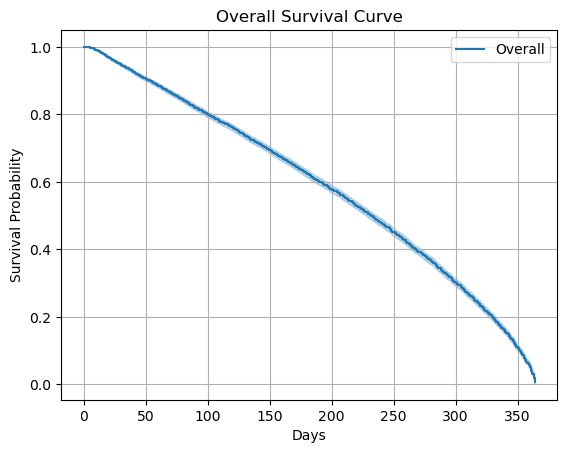

In [35]:

# Overall survival curve
kmf.fit(durations=data['event_time'], event_observed=data['event_observed'], label='Overall')
kmf.plot_survival_function(ci_show=True)
plt.title('Overall Survival Curve')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

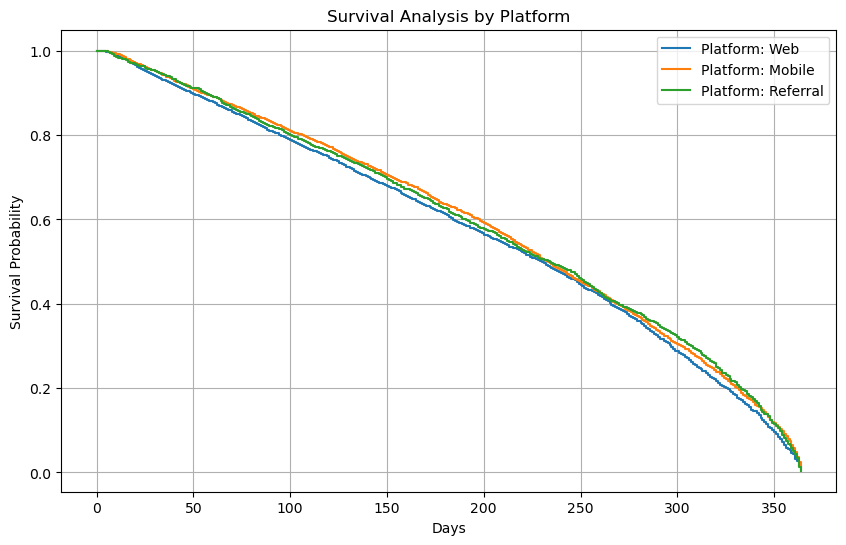

In [36]:


# Platform-wise survival curves
plt.figure(figsize=(10, 6))
for platform_name in data['platform'].unique():
    kmf.fit(
        durations=data[data['platform'] == platform_name]['event_time'],
        event_observed=data[data['platform'] == platform_name]['event_observed'],
        label=f'Platform: {platform_name}'
    )
    kmf.plot_survival_function(ci_show=False)
plt.title('Survival Analysis by Platform')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)
plt.show()

In [37]:

# Step 4: Cox Proportional Hazards Model
cph = CoxPHFitter()
data['platform_encoded'] = data['platform'].astype('category').cat.codes
cph.fit(data[['event_time', 'event_observed', 'platform_encoded', 'total_purchase']], duration_col='event_time', event_col='event_observed')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 10000 total observations, 2989 right-censored observations>
             duration col = 'event_time'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 7011
   partial log-likelihood = -57596.41
         time fit was run = 2025-01-13 03:30:28 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
platform_encoded   0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
total_purchase    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                   cmp to     z    p   -log2(p)
covariate                                      
platform_encoded     0.00  2.77 0.01       7.47
total_purchase       0.00 -0.29 0.77       0.38
---
Concordance = 0.51
Partial AIC = 115196.82
log-likelihood ratio test = 7.74 on 2 df
-log2(p) of ll-ratio test = 5.58

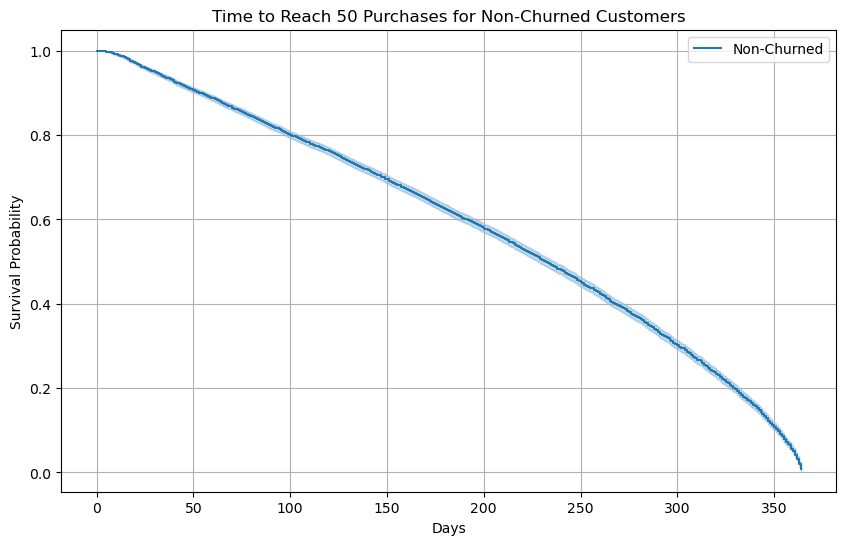

In [38]:

# Step 5: Additional Analysis
# Analyze time to 50 purchases (conditional on not churning)
non_churned = data[~data['churned']]
kmf.fit(
    durations=non_churned['event_time'],
    event_observed=non_churned['event_observed'],
    label='Non-Churned'
)
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Time to Reach 50 Purchases for Non-Churned Customers')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [39]:


# Save cleaned dataset
data.to_csv('cleaned_customer_data.csv', index=False)


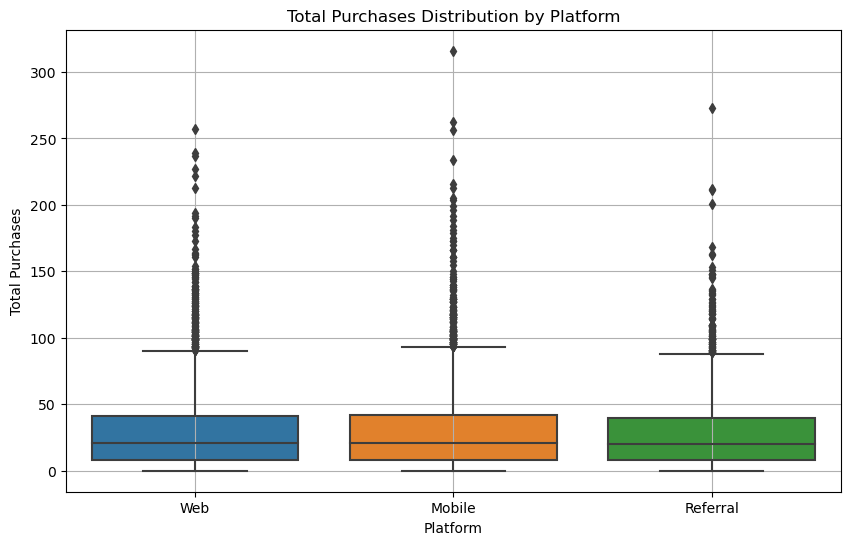

In [40]:

# Visualize distribution of purchases
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='total_purchase', data=data)
plt.title('Total Purchases Distribution by Platform')
plt.ylabel('Total Purchases')
plt.xlabel('Platform')
plt.grid(True)
plt.show()




In [41]:
# Output: Dataframe ready for further exploration
data.head()

,customer_number,customer_register_time,platform,last_login,total_purchase,redeemed_amount,lost,gap_less_than_2_weeks,churned,censored,event_time,event_observed,platform_encoded
0,1,2023-04-13,Web,2024-01-16,10,0,False,False,False,False,278,True,2
1,2,2023-12-15,Mobile,2024-01-15,2,0,False,False,False,False,31,True,0
2,3,2023-09-28,Mobile,2024-08-25,75,10,False,False,False,True,332,False,0
3,4,2023-04-17,Mobile,2023-11-28,18,50,False,False,False,True,225,False,0
4,5,2023-03-13,Mobile,2023-07-17,6,20,True,False,False,True,126,False,0


In [44]:
# Step 6: Simulating Interventions
# Add a hypothetical intervention flag
data['intervention'] = (data['lost']) & (np.random.rand(len(data)) < 0.5)  # 50% chance to receive intervention

# Encode the intervention
data['intervention_encoded'] = data['intervention'].astype(int)

# Re-fit the Cox model with intervention included
cph_intervention = CoxPHFitter()
cph_intervention.fit(data[['event_time', 'event_observed', 'platform_encoded', 'total_purchase', 'redeemed_amount', 'intervention_encoded']], 
                     duration_col='event_time', event_col='event_observed')

# Print the summary of the new model
cph_intervention.print_summary()

C:\Users\lakin\AppData\Roaming\Python\Python311\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column redeemed_amount have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_observed'].astype(bool)
>>> print(df.loc[events, 'redeemed_amount'].var())
>>> print(df.loc[~events, 'redeemed_amount'].var())

A very low variance means that the column redeemed_amount completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\lakin\AppData\Roaming\Python\Python311\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 1.576. This may imply non-unique solutions

<lifelines.CoxPHFitter: fitted with 10000 total observations, 2989 right-censored observations>
             duration col = 'event_time'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 7011
   partial log-likelihood = -54585.27
         time fit was run = 2025-01-13 03:31:29 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
platform_encoded       0.03       1.03       0.01             0.00             0.05                 1.00                 1.05
total_purchase        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
redeemed_amount       -1.70       0.18      15.32           -31.73            28.34                 0.00             2.02e+12
intervention_encoded   1.20       3.31       0.03             1.13             1.26                 3.10                 3.54

                       cmp to     z      p   -log2(p)
covariate                                            
platform_encoded         0.00  2.00   0.05       4.46
total_purchase           0.00 -0.51   0.61       0.71
redeemed_amount          0.00 -0.11   0.91       0.13
intervention_encoded     0.00 34.87 <0.005     882.44
---
Concordance = 0.70
Partial AIC = 109178.54
log-likelihood ratio test = 6030.02 on 4 df
-log2(p) of ll-ratio test = inf

<Figure size 1000x600 with 0 Axes>

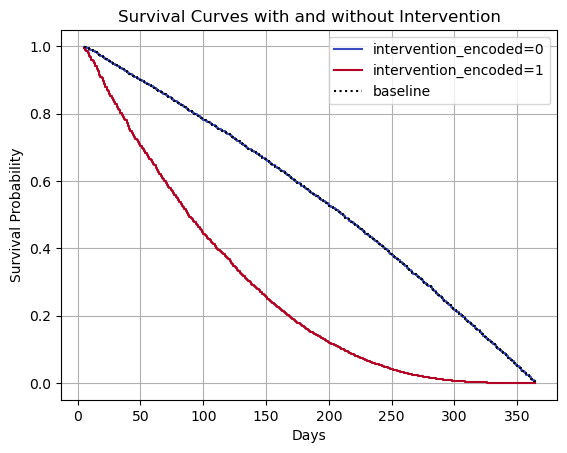

In [47]:
# Visualize the effect of intervention using the updated method
plt.figure(figsize=(10, 6))
cph_intervention.plot_partial_effects_on_outcome(
    covariates='intervention_encoded',
    values=[0, 1],  # 0 = No Intervention, 1 = Intervention
    cmap='coolwarm'
)
plt.title('Survival Curves with and without Intervention')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


In [48]:

# Simulating Reduced Hazard Rate
# Apply a hypothetical 20% reduction in hazard rate for customers with interventions
data['adjusted_hazard'] = np.where(data['intervention'], 0.8 * data['event_observed'], data['event_observed'])



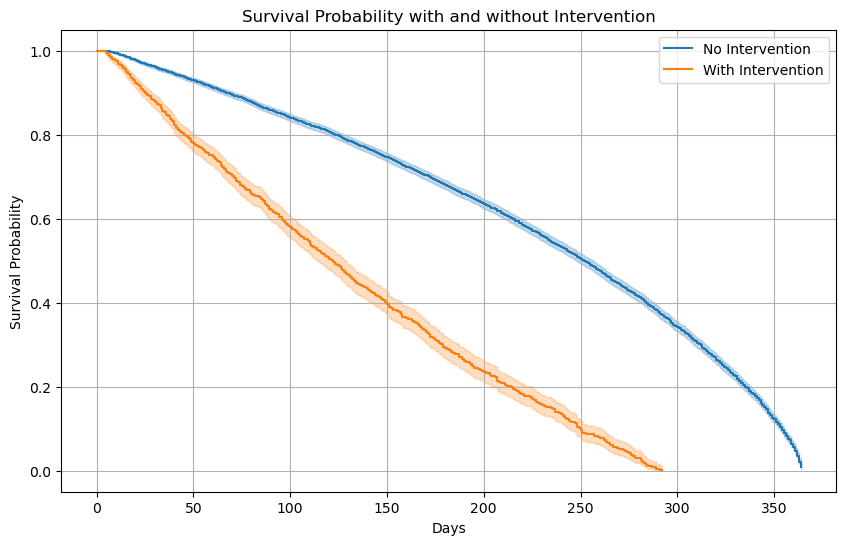

In [51]:
# Re-run the Kaplan-Meier Analysis
kmf_intervention = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

# Without intervention
kmf_intervention.fit(durations=data[data['intervention'] == 0]['event_time'], 
                     event_observed=data[data['intervention'] == 0]['event_observed'], label='No Intervention')
kmf_intervention.plot_survival_function(ci_show=True)

# With intervention
kmf_intervention.fit(durations=data[data['intervention'] == 1]['event_time'], 
                     event_observed=data[data['intervention'] == 1]['event_observed'], label='With Intervention')
kmf_intervention.plot_survival_function(ci_show=True)
plt.title('Survival Probability with and without Intervention')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
# Save cleaned dataset
data.to_csv('cleaned_customer_data_with_intervention.csv', index=False)

# Output: Dataframe ready for further exploration
data.head()

,customer_number,customer_register_time,platform,last_login,total_purchase,redeemed_amount,lost,gap_less_than_2_weeks,churned,censored,event_time,event_observed,platform_encoded,intervention,intervention_encoded,adjusted_hazard
0,1,2023-04-13,Web,2024-01-16,10,0,False,False,False,False,278,True,2,False,0,1.0
1,2,2023-12-15,Mobile,2024-01-15,2,0,False,False,False,False,31,True,0,False,0,1.0
2,3,2023-09-28,Mobile,2024-08-25,75,10,False,False,False,True,332,False,0,False,0,0.0
3,4,2023-04-17,Mobile,2023-11-28,18,50,False,False,False,True,225,False,0,False,0,0.0
4,5,2023-03-13,Mobile,2023-07-17,6,20,True,False,False,True,126,False,0,False,0,0.0
